In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/miem-hse-ais-2022-lab-02/sample_submission.csv
/kaggle/input/miem-hse-ais-2022-lab-02/valid.csv
/kaggle/input/miem-hse-ais-2022-lab-02/train.csv
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid0192.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid0024.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid1062.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid0055.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid1523.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid1233.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid0364.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid0311.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid0322.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid1219.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid1121.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid0838.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid1501.jpg
/kaggle/input/miem-hse-ais-2022-lab-02/valid/valid1480.jpg
/kaggle/input/m

Получение путей до всех изображений:

In [25]:
import glob
train_images = sorted(glob.glob('../input/miem-hse-ais-2022-lab-02/train/*.jpg'))
valid_images = sorted(glob.glob('../input/miem-hse-ais-2022-lab-02/valid/*.jpg'))
test_images = sorted(glob.glob('../input/miem-hse-ais-2022-lab-02/test/*.jpg'))

print('Число тренировочных изображений: {}'.format(len(train_images)))
print('Число валидационных изображений: {}'.format(len(valid_images)))
print('Число тестовых изображений: {}'.format(len(test_images)))

Число тренировочных изображений: 9003
Число валидационных изображений: 1536
Число тестовых изображений: 4523


Чтение и вывод изображения на экран:

Размеры изображения: (384, 512, 3)


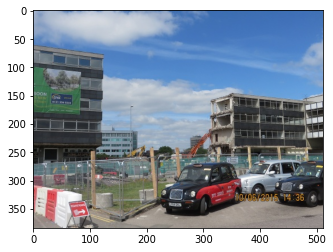

In [10]:
import matplotlib.pyplot as plt
import cv2

single_image = cv2.imread(train_images[0])
print('Размеры изображения: {}'.format(single_image.shape))

# cv2 хранит изображения в BGR формате надо преобразовать в RGB для показа на экран
image_to_show = single_image[:, :, ::-1]
plt.imshow(image_to_show)

Чтение данных:

In [4]:
import pandas as pd

train = pd.read_csv('../input/miem-hse-ais-2022-lab-02/train.csv')
valid = pd.read_csv('../input/miem-hse-ais-2022-lab-02/valid.csv')

train.head(15)

,id,target_people
0,train0001.jpg,0
1,train0002.jpg,0
2,train0003.jpg,1
3,train0004.jpg,0
4,train0005.jpg,0
5,train0006.jpg,0
6,train0007.jpg,1
7,train0008.jpg,1
8,train0009.jpg,1
9,train0010.jpg,0


In [12]:
valid.head()

,id,target_people
0,valid0001.jpg,1
1,valid0002.jpg,0
2,valid0003.jpg,0
3,valid0004.jpg,0
4,valid0005.jpg,0


## Ayгмeнтaция изoбpaжeний

In [47]:
import torch
import torch.optim as optim
import torchvision as trv
from torchvision.models.mobilenet import mobilenet_v2
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss
from torch import nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset

In [51]:
import matplotlib.pyplot as plt
from albumentations import *
import cv2

transform_comp = trv.transforms.Compose([trv.transforms.ToPILImage(),
                                  trv.transforms.Resize((300, 300)),
                                  trv.transforms.ToTensor()])

def strong_aug():
    return Compose([
        HorizontalFlip(p=0.5),
        # VerticalFlip(p=0.5),
        # RandomRotate90(p=1.0),
        Resize(300,300),
        RGBShift(p=0.5, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        OneOf([
            MedianBlur(p=1.0, blur_limit=7),
            Blur(p=1.0, blur_limit=7),
            GaussianBlur(p=1.0, blur_limit=7),
        ], p=0.2),
        OneOf([
            IAAAdditiveGaussianNoise(p=1.0),
            GaussNoise(p=1.0),
        ], p=0.2),
        OneOf([
            ElasticTransform(p=1.0, alpha=1.0, sigma=30, alpha_affine=20),
            GridDistortion(p=1.0, num_steps=5, distort_limit=0.3),
            OpticalDistortion(p=1.0, distort_limit=0.5, shift_limit=0.5)
        ], p=0.2)
    ],  p=1.0)

def aug_transform(image):
    img_aug = strong_aug()(image=image)
    img_aug = img_aug['image'][:, :, ::-1]
    img_aug = transform_comp(img_aug)
    return img_aug


##def trans():
  ##  return Compose([
    ##    Resize(300,300)
      ##  ],  p=1.0)

##def resize_transform(image):
  ##  img_aug = trans()(image=image)
    ##img_aug = img_aug['image'][:, :, ::-1]
    ##return img_aug

Kлacc Dataset для задачи

In [65]:
import os
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import DataLoader, Dataset


class DatasetPeople(Dataset):
    
    def __init__(self, file_path, root_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.root_path = root_path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.root_path, self.data.loc[index, 'id'])
        image = cv2.imread(image_path)
        label = self.data.loc[index, 'target_people']
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label


train_file_path = '../input/miem-hse-ais-2022-lab-02/train.csv'
valid_file_path = '../input/miem-hse-ais-2022-lab-02/valid.csv'
train_images_path = '../input/miem-hse-ais-2022-lab-02/train/'
valid_images_path = '../input/miem-hse-ais-2022-lab-02/valid/'
test_file_path = '../input/miem-hse-ais-2022-lab-02/sample_submission.csv'
test_images_path = '../input/miem-hse-ais-2022-lab-02/test/'

train_dataset = DatasetPeople(train_file_path, train_images_path, transform_comp)
test_dataset = DatasetPeople(test_file_path, test_images_path, transform_comp)
valid_dataset = DatasetPeople(valid_file_path, valid_images_path, transform_comp)
print('Length of train: {}'.format(len(train_dataset)))
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    print(img.shape, label)
    if i > 10:
        break

Length of train: 9003
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 1
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 1
torch.Size([3, 300, 300]) 1
torch.Size([3, 300, 300]) 1
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 0


In [66]:
for i in range(2):
    transformed = DatasetPeople(train_file_path, train_images_path, aug_transform)
    train_dataset = torch.utils.data.ConcatDataset([transformed, train_dataset])

print('Length of train: {}'.format(len(train_dataset)))
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    print(img.shape, label)
    if i > 10:
        break

Length of train: 27009
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 1
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 1
torch.Size([3, 300, 300]) 1
torch.Size([3, 300, 300]) 1
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 0
torch.Size([3, 300, 300]) 0


In [56]:
def train(model, device, train_loader, optimizer, epoch):
    log_interval = 20
    loss_func = CrossEntropyLoss()
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.repeat(1, 1, 1, 1)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [57]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_func = CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data = data.repeat(1, 1, 1, 1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [68]:
batch_size = 64
learning_rate = 1.0
reduce_lr_gamma = 0.6
epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: {} Epochs: {} Batch size: {}'.format(device, epochs, batch_size))

kwargs = {'batch_size': batch_size}
if torch.cuda.is_available():
    kwargs.update({'num_workers': 1, 'pin_memory': True})

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, **kwargs)
valid_loader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, **kwargs)
print('Number of train batches: {} Number of valid batches: {}'.format(len(train_loader), len(valid_loader)))

Device: cuda Epochs: 20 Batch size: 64
Number of train batches: 423 Number of valid batches: 24


In [59]:
model = mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [ ]:
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=1, gamma=reduce_lr_gamma)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, valid_loader)
    scheduler.step()

torch.save(model.state_dict(), "mnist_cnn.pts")

Train Epoch: 1 [0/27009 (0%)]	Loss: 0.307042
Train Epoch: 1 [1280/27009 (5%)]	Loss: 0.638855
Train Epoch: 1 [2560/27009 (9%)]	Loss: 0.260714
Train Epoch: 1 [3840/27009 (14%)]	Loss: 0.379804
Train Epoch: 1 [5120/27009 (19%)]	Loss: 0.309372
Train Epoch: 1 [6400/27009 (24%)]	Loss: 0.369513
Train Epoch: 1 [7680/27009 (28%)]	Loss: 0.494572
Train Epoch: 1 [8960/27009 (33%)]	Loss: 0.353839
Train Epoch: 1 [10240/27009 (38%)]	Loss: 0.369921
Train Epoch: 1 [11520/27009 (43%)]	Loss: 0.276538
Train Epoch: 1 [12800/27009 (47%)]	Loss: 0.218647
Train Epoch: 1 [14080/27009 (52%)]	Loss: 0.389120
Train Epoch: 1 [15360/27009 (57%)]	Loss: 0.382792
Train Epoch: 1 [16640/27009 (61%)]	Loss: 0.404766
Train Epoch: 1 [17920/27009 (66%)]	Loss: 0.452884
Train Epoch: 1 [19200/27009 (71%)]	Loss: 0.372718
Train Epoch: 1 [20480/27009 (76%)]	Loss: 0.418666
Train Epoch: 1 [21760/27009 (80%)]	Loss: 0.283258
Train Epoch: 1 [23040/27009 (85%)]	Loss: 0.236687
Train Epoch: 1 [24320/27009 (90%)]	Loss: 0.330293
Train Epoch: 1

In [26]:
ids = test_images
submission = pd.DataFrame(ids, columns=['id'])
predictions = []
real = []

func = nn.Sigmoid()

with torch.no_grad():
    for data, target in test_loader:
        data = data.repeat(1, 1, 1, 1)
        data = data.to(device)
        output = func(model(data))
        pred = output
        predictions += list(pred[:, 1].cpu().numpy())
        real += list(target.numpy())
    
submission['target_people'] = predictions
submission.to_csv('submission.csv', index=False)
print('Submission saved in: {}'.format('submission.csv'))

Submission saved in: submission.csv


In [33]:
submission =pd.read_csv('../input/miem-hse-ais-2022-lab-02/sample_submission.csv')
predictions = []
real = []
func = nn.Sigmoid()

with torch.no_grad():
    for data, target in test_loader:
        data = data.repeat(1, 1, 1, 1)
        data = data.to(device)
        output = model(data)
        output = func(output)

        pred = output[:,1].cpu().numpy()
        predictions += list(pred)
        real += list(target.numpy())
        
submission['target_people'] = predictions

submission.to_csv('submission.csv', index=False)
print('Submission saved in: {}'.format('submission.csv'))

Submission saved in: submission.csv
